In [5]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import emcee
import astropy
from astropy.time import Time
import h5py
import corner
from matplotlib.ticker import MaxNLocator, ScalarFormatter
from multiprocessing import Pool
import matplotlib.ticker as mticker
from mc3.stats import time_avg
from astropy.modeling.models import BlackBody
from astropy import units as u
from astropy.visualization import quantity_support
import matplotlib.patches as patches
from scipy.optimize import curve_fit

In [9]:
eclipses = ['1', '2', '3']
a = '5'
#aperture = ['4', '7', '12']
segments = ['0000', '0001', '0002', '0003', '0004']

# Initialize dictionaries to hold arrays for each aperture
time_arr = {e: [] for e in eclipses}
aplev_arr = {e: [] for e in eclipses}
aperr_arr = {e: [] for e in eclipses}
centroid_x_arr = {e: [] for e in eclipses}
centroid_y_arr = {e: [] for e in eclipses}


for e in eclipses:
    for seg in segments:
        if e == '1':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+ e +'/LHS1140c-S3_ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        elif e == '2':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+ e +'/Stage3/S3_2024-07-22_lhs1140c_run1/ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        elif e == '3':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+ e +'/Stage3/S3_2024-08-05_lhs1140c_run1/ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        with h5py.File(path, 'r') as file:     # open the file
            time_arr[e] = np.append(time_arr[e], np.array(file['time']))
            aplev_arr[e] = np.append(aplev_arr[e], np.array(file['aplev']))
            aperr_arr[e] = np.append(aperr_arr[e], np.array(file['aperr']))
            centroid_x_arr[e] = np.append(centroid_x_arr[e], np.array(file['centroid_x']))
            centroid_y_arr[e] = np.append(centroid_y_arr[e], np.array(file['centroid_y']))

    time_arr[e] = np.array(time_arr[e])
    aplev_arr[e] = np.array(aplev_arr[e])
    aperr_arr[e] = np.array(aperr_arr[e])
    centroid_x_arr[e] = np.array(centroid_x_arr[e])
    centroid_y_arr[e] = np.array(centroid_y_arr[e])

[60275.77646891 60275.77659717 60275.77672543 ... 60275.93794689
 60275.93807515 60275.93820341]


1262 1262 1262 3786 3786


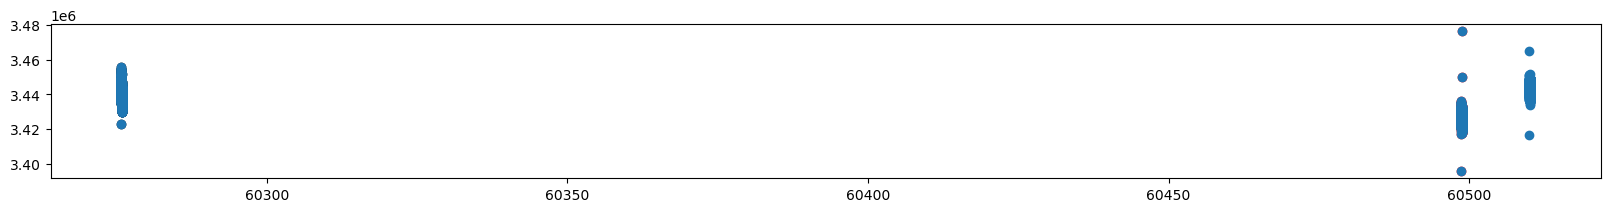

In [22]:
len1 = len(time_arr['1'])
len2 = len(time_arr['2'])
len3 = len(time_arr['3'])
time = np.concatenate((time_arr['1'], time_arr['2'], time_arr['3']))
aplev = np.concatenate((aplev_arr['1'], aplev_arr['2'], aplev_arr['3']))

print(len1, len2, len3, (len1+len2+len3), len(time))

plt.figure(figsize=(20, 2))
plt.plot(time[0:len1], aplev_arr['1'], 'ok')
plt.plot(time[len1:(len1+len2)], aplev_arr['2'], 'or')
plt.plot(time, aplev,'o')



In [ ]:
def transit_model(time, t_s, fp):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 58388.7939*24
    params.per = 3.777940*24              #orbital period in hours
    params.rp = 0.0539                    #planet radius (in units of stellar radii) # check that this is ratio of radii -> 0.0539 is charles value
    params.a = 26.57                      #semi-major axis (in units of stellar radii)
    params.inc = 89.8                     #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"        #limb darkening model
    params.u = [0.16, 0.22]               #limb darkening coefficients, values from cadieux 2024b
    params.fp = fp                        #planet to star flux ratio
    params.t_secondary = t_s

    m = batman.TransitModel(params, time, transittype="secondary")
    flux = m.light_curve(params)
    return flux
